In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# For mutliple devices (GPUs: 4, 5, 6, 7)
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
#!/usr/bin/env python3

"""
Demonstrates how to:
    * use the MAML wrapper for fast-adaptation,
    * use the benchmark interface to load mini-ImageNet, and
    * sample tasks and split them in adaptation and evaluation sets.

To contrast the use of the benchmark interface with directly instantiating mini-ImageNet datasets and tasks, compare with `protonet_miniimagenet.py`.
"""

import random
import numpy as np

import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import learn2learn as l2l
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)
import os


Bad key "text.kerning_factor" on line 4 in
/home/khanhi83/anaconda3/envs/PY3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:


def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)


def fast_adapt(batch, learner, loss, adaptation_steps, shots, ways, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(shots*ways) * 2] = True
    evaluation_indices = torch.from_numpy(~adaptation_indices)
    adaptation_indices = torch.from_numpy(adaptation_indices)
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

    # Adapt the model
    for step in range(adaptation_steps):
        adaptation_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(adaptation_error)

    # Evaluate the adapted model
    predictions = learner(evaluation_data)
    evaluation_error = loss(predictions, evaluation_labels)
    evaluation_accuracy = accuracy(predictions, evaluation_labels)
    return evaluation_error, evaluation_accuracy


def perform_experiment(dataset,
        ways=5,
        shots=5,
        meta_lr=0.003,
        fast_lr=0.5,
        meta_batch_size=32,
        adaptation_steps=1,
        num_iterations=60000,
        cuda=True,
        seed=42,
):
    
    Meta_Train_Accuracy = []
    Meta_Train_Error = []
    Meta_Val_Accuracy = []
    Meta_Val_Error = []
#     Iterations = []
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    device = torch.device('cpu')
    if cuda and torch.cuda.device_count():
        torch.cuda.manual_seed(seed)
        device = torch.device('cuda')

    # Create Tasksets using the benchmark interface
    tasksets = l2l.vision.benchmarks.get_tasksets(dataset,
                                                  train_samples=2*shots,
                                                  train_ways=ways,
                                                  test_samples=2*shots,
                                                  test_ways=ways,
                                                  root='~/data',
    )

    # Create model
    model = l2l.vision.models.MiniImagenetCNN(ways)
    model.to(device)
    maml = l2l.algorithms.MAML(model, lr=fast_lr, first_order=False)
    opt = optim.Adam(maml.parameters(), meta_lr)
    loss = nn.CrossEntropyLoss(reduction='mean')

    for iteration in range(num_iterations):
        opt.zero_grad()
        meta_train_error = 0.0
        meta_train_accuracy = 0.0
        meta_valid_error = 0.0
        meta_valid_accuracy = 0.0
        for task in range(meta_batch_size):
            # Compute meta-training loss
            learner = maml.clone()
            batch = tasksets.train.sample()
            evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                               learner,
                                                               loss,
                                                               adaptation_steps,
                                                               shots,
                                                               ways,
                                                               device)
            evaluation_error.backward()
            meta_train_error += evaluation_error.item()
            meta_train_accuracy += evaluation_accuracy.item()

            # Compute meta-validation loss
            learner = maml.clone()
            batch = tasksets.validation.sample()
            evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                               learner,
                                                               loss,
                                                               adaptation_steps,
                                                               shots,
                                                               ways,
                                                               device)
            meta_valid_error += evaluation_error.item()
            meta_valid_accuracy += evaluation_accuracy.item()

        # Print some metrics
#         print('\n')
#         print('Iteration', iteration)
#         print('Meta Train Error', meta_train_error / meta_batch_size)
#         print('Meta Train Accuracy', meta_train_accuracy / meta_batch_size)
#         print('Meta Valid Error', meta_valid_error / meta_batch_size)
#         print('Meta Valid Accuracy', meta_valid_accuracy / meta_batch_size)
        
        meta_train_error =  meta_train_error / meta_batch_size
        meta_train_accuracy = meta_train_accuracy / meta_batch_size
        meta_val_error =  meta_valid_error / meta_batch_size
        meta_val_accuracy = meta_valid_accuracy / meta_batch_size
        if(iteration % 32 ==0):
            print('\n')
            print('Iteration', iteration)
            print('Meta Train Error', meta_train_error)
            print('Meta Train Accuracy', meta_train_accuracy)
            print('Meta Valid Error', meta_val_error)
            print('Meta Valid Accuracy', meta_val_accuracy)

        Meta_Train_Accuracy.append(meta_train_accuracy)
        Meta_Train_Error.append(meta_train_error)
        Meta_Val_Accuracy.append(meta_val_accuracy)
        Meta_Val_Error.append(meta_val_error)

        # Average the accumulated gradients and optimize
        for p in maml.parameters():
            p.grad.data.mul_(1.0 / meta_batch_size)
        opt.step()

    meta_test_error = 0.0
    meta_test_accuracy = 0.0
    for task in range(meta_batch_size):
        # Compute meta-testing loss
        learner = maml.clone()
        batch = tasksets.test.sample()
        evaluation_error, evaluation_accuracy = fast_adapt(batch,
                                                           learner,
                                                           loss,
                                                           adaptation_steps,
                                                           shots,
                                                           ways,
                                                           device)
        meta_test_error += evaluation_error.item()
        meta_test_accuracy += evaluation_accuracy.item()
#     print('Meta Test Error', meta_test_error / meta_batch_size)
#     print('Meta Test Accuracy', meta_test_accuracy / meta_batch_size)
    Meta_Test_Error = meta_test_error / meta_batch_size
    print('Meta Test Error', Meta_Test_Error)
    Meta_Test_Accuracy = meta_test_accuracy / meta_batch_size
    print('Meta Test Accuracy', Meta_Test_Accuracy)
    
    if not os.path.exists('plots'):
        os.makedirs('plots')
    if not os.path.exists('plots/acc'):
        os.makedirs('plots/acc')
    if not os.path.exists('plots/loss'):
        os.makedirs('plots/loss')
        
    ###### Plot Accuracies ######
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(list(range(0, len(Meta_Train_Accuracy))), Meta_Train_Accuracy, label="Meta Train ")
    ax.plot(list(range(0, len(Meta_Val_Accuracy))), Meta_Val_Accuracy, label="Meta Val")
#     ax.text((len(Meta_Val_Accuracy)/2), 0, 'Meta Test:{0}'.format(round(meta_test_accuracy, 2)), style='italic',
#         bbox={'facecolor': 'red', 'alpha': 0.25, 'pad': 5})
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.5, 'Meta Test:{0}'.format(round(Meta_Test_Accuracy, 2)), transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.title('Adaption')
    plt.xlabel('Iteration')
    plt.ylabel('Meta Accuracy')
    ax.legend()
    plt.savefig('./plots/acc/{0}_ways_{1}_shots_{2}_Acc_I_{3}.png'.format(dataset, ways, shots, num_iterations))
    ###### Plot Accuracies ######

    ###### Plot Errors ######
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(list(range(0, len(Meta_Train_Error))), Meta_Train_Error, label="Meta Train ")
    ax.plot(list(range(0, len(Meta_Val_Error))), Meta_Val_Accuracy, label="Meta Val Lss")
#     ax.text((len(Meta_Val_Accuracy)/2),0, 'Meta Test Accuracy:{0}  Meta Test Loss:{1}'.format(round(meta_test_accuracy, 2),
#                               round(meta_test_error, 2)), style='italic',
#         bbox={'facecolor': 'red', 'alpha': 0.25, 'pad': 5})
    ax.text(0.05, 0.5, 'MTestAcc:{0}  MTestLoss:{1}'.format(round(Meta_Test_Accuracy, 2),
                                           round(Meta_Test_Error, 2)), transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.title('Adaption')
    plt.xlabel('Iteration')
    plt.ylabel('Meta Loss')
    ax.legend()
    plt.savefig('./plots/loss/{0}_ways_{1}_shots_{2}_Loss_I_{3}.png'.format(dataset, ways, shots, num_iterations))
    ###### Plot Errors ######






Iteration 0
Meta Train Error 6.996490091085434
Meta Train Accuracy 0.21749999094754457
Meta Valid Error 7.403145283460617
Meta Valid Accuracy 0.21374999172985554


Iteration 32
Meta Train Error 1.4757372960448265
Meta Train Accuracy 0.3774999901652336
Meta Valid Error 1.5148613788187504
Meta Valid Accuracy 0.33499999064952135


Iteration 64
Meta Train Error 1.472817212343216
Meta Train Accuracy 0.3637499886099249
Meta Valid Error 1.4684696048498154
Meta Valid Accuracy 0.3649999916087836


Iteration 96
Meta Train Error 1.4054855518043041
Meta Train Accuracy 0.41374998772516847
Meta Valid Error 1.3974303379654884
Meta Valid Accuracy 0.38124998891726136


Iteration 128
Meta Train Error 1.3701085448265076
Meta Train Accuracy 0.4124999875202775
Meta Valid Error 1.4431582540273666
Meta Valid Accuracy 0.41374998819082975


Iteration 160
Meta Train Error 1.4111768919974566
Meta Train Accuracy 0.39874998945742846
Meta Valid Error 1.4000484608113766
Meta Valid Accuracy 0.4037499902769923


Ite



Iteration 1600
Meta Train Error 0.9038502369076014
Meta Train Accuracy 0.6449999823234975
Meta Valid Error 1.1063604522496462
Meta Valid Accuracy 0.5562499854713678


Iteration 1632
Meta Train Error 0.8316977806389332
Meta Train Accuracy 0.6737499795854092
Meta Valid Error 1.1072102300822735
Meta Valid Accuracy 0.5424999864771962


Iteration 1664
Meta Train Error 0.8430547574535012
Meta Train Accuracy 0.6712499801069498
Meta Valid Error 1.0641416553407907
Meta Valid Accuracy 0.5712499869987369


Iteration 1696
Meta Train Error 0.9332279022783041
Meta Train Accuracy 0.6399999838322401
Meta Valid Error 1.1029308084398508
Meta Valid Accuracy 0.5512499874457717


Iteration 1728
Meta Train Error 0.8703517885878682
Meta Train Accuracy 0.6412499798461795
Meta Valid Error 1.0755242351442575
Meta Valid Accuracy 0.5762499878183007


Iteration 1760
Meta Train Error 0.8938478492200375
Meta Train Accuracy 0.6587499836459756
Meta Valid Error 1.0782889630645514
Meta Valid Accuracy 0.571249986067414



Iteration 3200
Meta Train Error 0.817446275614202
Meta Train Accuracy 0.6799999801442027
Meta Valid Error 1.0141364876180887
Meta Valid Accuracy 0.598749983124435


Iteration 3232
Meta Train Error 0.791101910173893
Meta Train Accuracy 0.696249975822866
Meta Valid Error 1.075308782979846
Meta Valid Accuracy 0.5799999879673123


Iteration 3264
Meta Train Error 0.7262999070808291
Meta Train Accuracy 0.7199999783188105
Meta Valid Error 0.9704683423042297
Meta Valid Accuracy 0.612499981187284


Iteration 3296
Meta Train Error 0.7658834187313914
Meta Train Accuracy 0.7024999810382724
Meta Valid Error 1.0306560331955552
Meta Valid Accuracy 0.6024999814108014


Iteration 3328
Meta Train Error 0.7690308219753206
Meta Train Accuracy 0.7074999809265137
Meta Valid Error 0.9989279108121991
Meta Valid Accuracy 0.622499986551702


Iteration 3360
Meta Train Error 0.7950497381389141
Meta Train Accuracy 0.7049999786540866
Meta Valid Error 1.0440335925668478
Meta Valid Accuracy 0.5999999828636646


Ite



Iteration 4800
Meta Train Error 0.7102746688760817
Meta Train Accuracy 0.7262499826028943
Meta Valid Error 1.0411234330385923
Meta Valid Accuracy 0.5799999861046672


Iteration 4832
Meta Train Error 0.7162460922263563
Meta Train Accuracy 0.7187499767169356
Meta Valid Error 1.0206708889454603
Meta Valid Accuracy 0.5724999830126762


Iteration 4864
Meta Train Error 0.6146593131124973
Meta Train Accuracy 0.7737499754875898
Meta Valid Error 1.0300287622958422
Meta Valid Accuracy 0.5862499875947833


Iteration 4896
Meta Train Error 0.7106749312952161
Meta Train Accuracy 0.7237499775364995
Meta Valid Error 0.9761864840984344
Meta Valid Accuracy 0.6087499838322401


Iteration 4928
Meta Train Error 0.7300542062148452
Meta Train Accuracy 0.7349999789148569
Meta Valid Error 0.9962953180074692
Meta Valid Accuracy 0.6199999805539846


Iteration 4960
Meta Train Error 0.758125551044941
Meta Train Accuracy 0.7237499766051769
Meta Valid Error 1.0187050513923168
Meta Valid Accuracy 0.5849999813362956



Iteration 6400
Meta Train Error 0.7476243656128645
Meta Train Accuracy 0.694999985396862
Meta Valid Error 1.057786975055933
Meta Valid Accuracy 0.5849999831989408


Iteration 6432
Meta Train Error 0.7148555098101497
Meta Train Accuracy 0.7287499783560634
Meta Valid Error 1.0268326383084059
Meta Valid Accuracy 0.5962499864399433


Iteration 6464
Meta Train Error 0.6992430500686169
Meta Train Accuracy 0.7362499767914414
Meta Valid Error 0.9713278338313103
Meta Valid Accuracy 0.6062499852851033


Iteration 6496
Meta Train Error 0.6729094022884965
Meta Train Accuracy 0.7474999818950891
Meta Valid Error 0.9554477613419294
Meta Valid Accuracy 0.6337499804794788


Iteration 6528
Meta Train Error 0.7098221154883504
Meta Train Accuracy 0.7299999846145511
Meta Valid Error 1.1816605692729354
Meta Valid Accuracy 0.5487499888986349


Iteration 6560
Meta Train Error 0.6566438125446439
Meta Train Accuracy 0.7462499812245369
Meta Valid Error 0.9794832039624453
Meta Valid Accuracy 0.6049999883398414




Iteration 8000
Meta Train Error 0.7401662487536669
Meta Train Accuracy 0.7262499798089266
Meta Valid Error 1.0982180964201689
Meta Valid Accuracy 0.566249986179173


Iteration 8032
Meta Train Error 0.6721406308934093
Meta Train Accuracy 0.7524999789893627
Meta Valid Error 1.0298546813428402
Meta Valid Accuracy 0.5849999841302633


Iteration 8064
Meta Train Error 0.6823349520564079
Meta Train Accuracy 0.7524999799206853
Meta Valid Error 1.00677827373147
Meta Valid Accuracy 0.5824999799951911


Iteration 8096
Meta Train Error 0.6677370774559677
Meta Train Accuracy 0.7462499774992466
Meta Valid Error 1.0210511982440948
Meta Valid Accuracy 0.5949999848380685


Iteration 8128
Meta Train Error 0.6046096277423203
Meta Train Accuracy 0.7712499685585499
Meta Valid Error 1.0561736952513456
Meta Valid Accuracy 0.5774999861605465


Iteration 8160
Meta Train Error 0.6363673866726458
Meta Train Accuracy 0.7662499770522118
Meta Valid Error 1.0763904172927141
Meta Valid Accuracy 0.587499987334013






Iteration 9600
Meta Train Error 0.6670060949400067
Meta Train Accuracy 0.7537499777972698
Meta Valid Error 1.0390388425439596
Meta Valid Accuracy 0.5962499845772982


Iteration 9632
Meta Train Error 0.7208412950858474
Meta Train Accuracy 0.7124999798834324
Meta Valid Error 1.071798788383603
Meta Valid Accuracy 0.5762499859556556


Iteration 9664
Meta Train Error 0.686449462082237
Meta Train Accuracy 0.733749981969595
Meta Valid Error 0.9462465960532427
Meta Valid Accuracy 0.6374999824911356


Iteration 9696
Meta Train Error 0.6974905664101243
Meta Train Accuracy 0.7549999766051769
Meta Valid Error 1.0772795844823122
Meta Valid Accuracy 0.5749999824911356


Iteration 9728
Meta Train Error 0.6711484687402844
Meta Train Accuracy 0.7512499801814556
Meta Valid Error 1.0725201908499002
Meta Valid Accuracy 0.5662499889731407


Iteration 9760
Meta Train Error 0.6807611910626292
Meta Train Accuracy 0.7324999757111073
Meta Valid Error 0.9962526429444551
Meta Valid Accuracy 0.5912499818950891



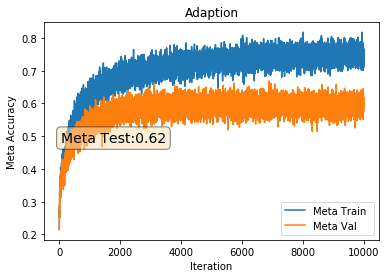

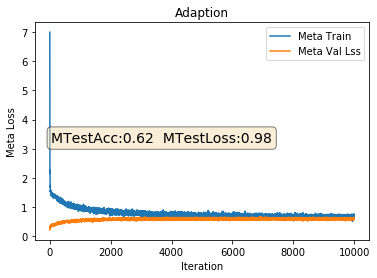

In [4]:
if __name__ == '__main__':
    perform_experiment(dataset='mini-imagenet',
    ways=5,
    shots=5,
    meta_lr=0.003,
    fast_lr=0.5,
    meta_batch_size=32,
    adaptation_steps=1,
    num_iterations=10000,
    cuda=True,
    seed=42)